<a href="https://colab.research.google.com/github/mrstew/quick_overton_scripts/blob/main/SMU_Reusable_Script_for_Article_Retrieval_(EA_edits).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import the necessary libraries
import json
import requests
import urllib
import pandas as pd
import csv

from google.colab import userdata
# Paste your API key in the "Secrets" tab in Google Colab
api_key = userdata.get('api_key')

# # Alternatively, uncomment and paste your api_key as a variable below
# api_key = "<YOUR API KEY>"


In [14]:
# This piece of code gives the URL that we want to retrieve the data from, and
# our unique API key to allow us to access it.
# Each API query returns a maximum of 50 results by default. We can access more
# results by paging through queries.
# In Jun 2025 there were 22 pages of results for SMU articles

base_url = "https://app.overton.io/articles.php?"
params = {"open_affiliations" : "Singapore Management University",
          "sort" : "date",
          "format" : "json",
          "api_key" : api_key}

# Some other parameters you could try include journal subject:
#
# "with_journal_subject": "Applied%20Psychology"
#
# To see the available journal subjects go to the articles tab in the Overton
# app:
# https://app.overton.io/articles.php?open_affiliations=Singapore+Management+University
#
# And Open Access status (data from OpenAlex / unpaywall):
#
# "oa_status": "green"
#
# e.g. To look at articles from SMU that are closed access you would do
# something like:
#
#params = {"open_affiliations" : "Singapore Management University",
#          "oa_status": "closed",
#          "sort" : "date",
#          "format" : "json",
#          "api_key" : api_key}
#
# Or... get everything using the example at the top of this block and then filter
# articles in / out based on those fields in the data that is returned.



In [15]:
# Fetch all pages of data from the API

# Save each page of results in a list
results = []

current_page = 1
next_page_url = base_url + urllib.parse.urlencode(params)

# Paginate through results until you reach the maximum number of pages,
# or return all the results (if less than the maximum number of pages)
while (next_page_url):
    print("Fetching page " + str(current_page))
    response = requests.get(next_page_url)

    # Get the JSON response
    data = response.json()

    # Append the results to the results list
    results += data["results"]["results"]

    # Get the URL for the next page from the results
    next_page_url = data['query']['next_page_url']

    # Incremement the current page number
    current_page += 1


Fetching page 1
Fetching page 2
Fetching page 3
Fetching page 4
Fetching page 5


In [18]:
# Parse the JSON to get: for each article: the DOI, title, total number of citations
# for each citing policy document: ID, title, and date of each policy document citation.
# The resulting data frame has one row per article / citing policy document pair.

# Simple fields to parse out from the JSON data for the article
simple_articles_fields = ["doi", "title", "citations", "oa_status", "with_journal_subject", "published_on"]

# Simple fields to parse out from the JSON data for the policy document
simple_policy_documents_fields = ["policy_document_id", "policy_source_id",
                                  "source_title", "document_title",
                                  "document_url", "country",
                                  "source_primary_classification",
                                  "source_secondary_classification",
                                  "published_on", ]
formatted_data = []

for result in results:

    formatted_result = {}

    for field in simple_articles_fields:
        formatted_result[field] = result.get(field)

    # Extract the citing document IDs
    for document_data in result["cited_by_documents"]:
        cited_by_document_data = formatted_result.copy()
        for field in simple_policy_documents_fields:
            cited_by_document_data["cited_by_" + field] = document_data.get(field)
        formatted_data.append(cited_by_document_data)

In [19]:
formatted_df = pd.DataFrame(formatted_data)

# Convert columns to dates
for column in ["published_on", "cited_by_published_on"]:
    formatted_df[column] = pd.to_datetime(formatted_df[column], errors="coerce").dt.date


# Calculate the timedelta between the article and policy document date
formatted_df["timedelta"] = formatted_df["cited_by_published_on"] - formatted_df["published_on"]
# Format as days. If one of the publication dates is missing or malformatted, the value will be null
formatted_df["timedelta"] = pd.to_timedelta(formatted_df["timedelta"]).dt.days

# Show the first few rows of the results
formatted_df.head()

,doi,title,citations,oa_status,with_journal_subject,published_on,cited_by_policy_document_id,cited_by_policy_source_id,cited_by_source_title,cited_by_document_title,cited_by_document_url,cited_by_country,cited_by_source_primary_classification,cited_by_source_secondary_classification,cited_by_published_on,timedelta
0,10.1017/s0022463424000353,Theatres of memory: Industrial heritage of 20t...,1,closed,"[Geography, Planning and Development, History,...",2025-01-16,govsg-2b86d6f81f2ac0b2ac819d87b177433a,govsg,Government of Singapore,Heritage Trail,https://www.roots.gov.sg/-/media/Roots/Images/...,Singapore,Public Sector,Government,2023-04-03,-654.0
1,10.1145/3695988,Large Language Models for Software Engineering...,1,closed,[Software],2024-11-30,tnonl-04e572383987b5d24a405e8248f42bac,tnonl,Nederlandse Organisatie voor Toegepast Natuurw...,Impact of software rejuvenation. Results of li...,https://repository.tno.nl/SingleDoc?docId=59301,Netherlands,Public Sector,Government,2024-01-01,-334.0
2,10.1287/mnsc.2022.03266,Buy Now Pay (Pain?) Later,3,closed,"[Strategy and Management, Management Science a...",2024-08-01,bankofnorway-4824704ee4b295378ca9706055006dbb,bankofnorway,Norges Bank,Buy Now Pay (Less) Later: Leveraging Private B...,https://www.norges-bank.no/aktuelt/publikasjon...,Norway,Public Sector,Government,2025-02-07,190.0
3,10.1287/mnsc.2022.03266,Buy Now Pay (Pain?) Later,3,closed,"[Strategy and Management, Management Science a...",2024-08-01,federalreserve-afd1ce84d16a54239be57b2a8bce9008,federalreserve,Federal Reserve,"""The Only Way I Could Afford It"": Who Uses BNP...",https://www.federalreserve.gov/econres/notes/f...,USA,Public Sector,Government,2024-12-20,141.0
4,10.1287/mnsc.2022.03266,Buy Now Pay (Pain?) Later,3,closed,"[Strategy and Management, Management Science a...",2024-08-01,sachverstandigenrat-048b07c5566f3f73ab28d30281...,sachverstandigenrat,Sachverständigenrat zur Begutachtung der gesam...,"VERSÄUMNISSE ANGEHEN, ENTSCHLOSSEN MODERNISIEREN",https://www.sachverstaendigenrat-wirtschaft.de...,Germany,Third Sector,Government,2024-11-11,102.0


In [20]:
num_citations = len(formatted_df)
num_negative_citations = (formatted_df["timedelta"] < 0).sum()
num_invalid_dates = formatted_df["timedelta"].isna().sum()

print(f"Number of citations: {num_citations}")
print(f"Number of negative citations: {num_negative_citations} ({100*num_negative_citations / num_citations:.1f}%)")
print(f"Number of invalid dates: {num_invalid_dates} ({100*num_invalid_dates / num_citations:.1f}%)")

Number of citations: 573
Number of negative citations: 14 (2.4%)
Number of invalid dates: 5 (0.9%)


In [11]:
# Describe the timedelta column (units = days)
# This includes negative dates in the average
print('Time from article publication to policy document citation (includes negative dates)')
formatted_df["timedelta"].describe()

Time from article publication to policy document citation (includes negative dates)


,timedelta
count,5095.000000
mean,2177.977233
std,1708.035507
min,-4933.000000
25%,850.000000
50%,1820.000000
75%,3248.500000
max,9189.000000


In [12]:
# You might choose to remove negative dates as these are probably errors!
print('Time from article publication to policy document citation (negative dates removed)')
formatted_df["timedelta"].loc[formatted_df["timedelta"] > 0].describe()

Time from article publication to policy document citation (negative dates removed)


,timedelta
count,4964.000000
mean,2255.545931
std,1651.303919
min,6.000000
25%,916.750000
50%,1883.500000
75%,3278.250000
max,9189.000000


<Axes: title={'center': 'Days from publication to policy citation'}, ylabel='Frequency'>

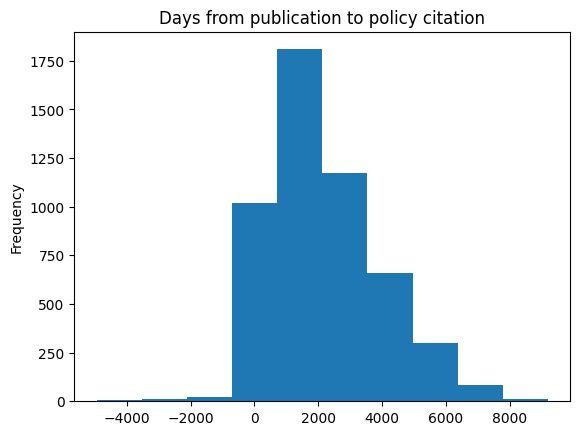

In [13]:
formatted_df["timedelta"].plot.hist(title="Days from publication to policy citation")